![Henry Logo](https://www.soyhenry.com/_next/static/media/HenryLogo.bb57fd6f.svg)

# RAG Avanzado - Patrones de Produccion

## Objetivos de aprendizaje

Al finalizar esta notebook seras capaz de:

1. Implementar **Multi-Query RAG** para mejorar el recall del retrieval
2. Usar **Ensemble Retriever** combinando busqueda semantica + keyword (BM25)
3. Aplicar **Contextual Compression** para extraer solo lo relevante de cada chunk
4. Construir un **RAG conversacional** con memoria de sesion
5. Evaluar la calidad del RAG con metricas cuantitativas
6. Comparar todos los patrones side-by-side

### Prerequisitos

Esta notebook asume que completaste `01-rag-fundamentos.ipynb` y entiendes:
- El pipeline basico: documentos -> chunks -> embeddings -> retrieval -> generacion
- LCEL chains con pipe operator
- ChromaDB como vector store

### Nota sobre implementacion

En esta notebook implementamos los patrones avanzados **desde los primitivos** de LangChain (prompts, runnables, retrievers). Esto permite entender exactamente que hace cada patron y adaptarlo a tu caso de uso.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from dotenv import find_dotenv, load_dotenv
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain_community.retrievers import BM25Retriever
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
import warnings
warnings.filterwarnings('ignore')

load_dotenv(find_dotenv())

llm = ChatOpenAI(model="gpt-4o", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
client = OpenAI()

print("Todas las dependencias cargadas correctamente.")

/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Todas las dependencias cargadas correctamente.


---
## Dataset: NovaTech Solutions

Reutilizamos la base de conocimiento de NovaTech con datos que el LLM no puede adivinar.

In [2]:
novatech_docs_raw = [
    """Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo completo 
    tienen derecho a 22 dias habiles de vacaciones al anio, acumulables hasta un maximo de 
    44 dias. Los primeros 6 meses son periodo de prueba y solo se acumulan 1.5 dias por mes. 
    Las vacaciones deben solicitarse con al menos 15 dias de anticipacion a traves del sistema 
    interno VacaTrack v3.2. El periodo de vacaciones colectivas es del 23 de diciembre al 2 de 
    enero. Los dias no utilizados se pueden compensar economicamente al 75% del valor diario 
    del salario base. El director de cada area debe aprobar las solicitudes en un plazo maximo 
    de 3 dias habiles.""",

    """Plan de Salud Corporativo NovaTech. La empresa ofrece cobertura medica a traves de 
    MediPlus Premium para todos los empleados y sus dependientes directos (conyuge e hijos 
    menores de 25 anios). La cobertura incluye: consultas generales y especialistas con copago 
    de $150 MXN, hospitalizacion con cobertura al 90%, medicamentos con descuento del 40% en 
    FarmaRed, dental basico incluido y dental estetico con 50% de cobertura. El tope anual de 
    cobertura es de $2,000,000 MXN por beneficiario. La empresa absorbe el 80% de la prima 
    mensual y el empleado el 20% restante via nomina.""",

    """Proceso de Onboarding en NovaTech Solutions. El programa de integracion dura 4 semanas 
    y sigue la metodologia NOVA-Start. Semana 1: Setup tecnico (laptop Dell XPS 15, cuentas, 
    VPN Cisco AnyConnect, acceso a GitLab), reunion con HR y firma de NDA. Semana 2: Sesiones 
    con cada area del producto, introduccion a la arquitectura de DataPulse y al stack 
    tecnologico. Semana 3: Asignacion de buddy (mentor) y primer ticket de practica en el 
    sprint actual. Semana 4: Evaluacion de onboarding con el tech lead y definicion de OKRs 
    del primer trimestre. Cada nuevo empleado recibe $5,000 MXN en credito para setup de 
    home office.""",

    """Stack Tecnologico de NovaTech Solutions. Backend: FastAPI 0.109 sobre Python 3.12, con 
    PostgreSQL 16 como base de datos principal y Redis 7.2 para cache y colas. Frontend: 
    React 18 con TypeScript 5.3, Next.js 14 para SSR, y TailwindCSS 3.4 para estilos. 
    Infraestructura: AWS con EKS (Kubernetes 1.28), Terraform para IaC, ArgoCD para GitOps 
    y Datadog para observabilidad. CI/CD: GitLab CI con runners dedicados en m6i.xlarge, 
    pipelines de ~8 minutos promedio. El monorepo tiene 340,000 lineas de codigo y 94% de 
    cobertura de tests. Arquitectura de microservicios con 23 servicios comunicados via gRPC 
    y eventos en Apache Kafka 3.6.""",

    """Sistema de Evaluaciones de NovaTech. Las evaluaciones de desempeno se realizan cada 6 
    meses usando la plataforma NovaPerf v2.1. El proceso incluye: autoevaluacion (20% del 
    peso), evaluacion del manager directo (40%), evaluacion de peers (30%) y evaluacion de 
    reportes directos si aplica (10%). La escala es de 1 a 5: 1-Necesita mejora, 2-En 
    desarrollo, 3-Cumple expectativas, 4-Supera expectativas, 5-Excepcional. Los empleados 
    con calificacion 4+ son elegibles para el programa de Fast Track que incluye aumento 
    salarial del 15-20% y acceso a proyectos estrategicos.""",

    """Politica de Trabajo Remoto NovaTech. La empresa opera bajo modelo hibrido 3-2: 3 dias 
    en oficina (martes, miercoles, jueves) y 2 dias remotos (lunes, viernes). Las oficinas 
    principales estan en Ciudad de Mexico (Torre NOVA, piso 12-15, Santa Fe) y Guadalajara 
    (WeWork Midtown). Se permite trabajo 100% remoto temporal por hasta 4 semanas al anio 
    con aprobacion del VP. Subsidio mensual de internet: $800 MXN. Silla ergonomica Herman 
    Miller Aeron en comodato. Reuniones de all-hands los miercoles a las 10:00 AM CST.""",

    """Programa de Capacitacion y Desarrollo NovaTech. Cada empleado cuenta con un presupuesto 
    anual de $25,000 MXN para capacitacion profesional. Esto cubre: cursos online (Udemy, 
    Coursera, Platzi), conferencias (hasta 2 al anio con viaticos incluidos), certificaciones 
    tecnicas (AWS, GCP, Kubernetes). La plataforma interna LearnHub tiene 150+ cursos creados 
    por empleados senior. Los viernes de 2-4 PM son 'Learning Hours' protegidas. El programa 
    de mentoria NOVA-Grow conecta juniors con seniors por 6 meses con sesiones quincenales.""",

    """DataPulse - Producto Principal de NovaTech Solutions. DataPulse es una plataforma de 
    analytics en tiempo real para empresas de e-commerce y fintech. Procesa en promedio 2.3 
    millones de eventos por minuto con una latencia p99 de 45ms. El SLA garantizado es de 
    99.95% de disponibilidad mensual, con creditos automaticos del 10% de la factura por cada 
    0.01% por debajo del SLA. DataPulse tiene 3 tiers: Starter ($2,500 USD/mes, hasta 10M 
    eventos/dia), Business ($8,000 USD/mes, hasta 100M eventos/dia) y Enterprise (precio 
    custom, eventos ilimitados, soporte 24/7). Actualmente 847 clientes en 12 paises.""",

    """Protocolo de Manejo de Incidentes NovaTech. Los incidentes se clasifican en 4 niveles: 
    SEV1 (caida total del servicio, respuesta en 5 minutos, war room inmediato), SEV2 
    (degradacion significativa, respuesta en 15 minutos), SEV3 (impacto menor, respuesta en 
    1 hora) y SEV4 (cosmetico, siguiente sprint). El on-call rota semanalmente entre 12 
    ingenieros senior con compensacion de $8,000 MXN por semana de guardia. Post-mortem 
    obligatorio para SEV1 y SEV2 dentro de 48 horas. El MTTR objetivo es de 30 minutos 
    para SEV1. Se usa PagerDuty para alertas y Slack #incidents para coordinacion.""",

    """Beneficios Adicionales NovaTech Solutions. Ademas del salario base, los empleados 
    reciben: vales de despensa por $3,500 MXN mensuales (TotalPass), fondo de ahorro con 
    aportacion patronal del 8%, seguro de vida por 48 meses de sueldo, bono anual basado 
    en desempeno (target del 15% del salario anual), programa de stock options despues de 
    2 anios de antiguedad (vesting de 4 anios con cliff de 1 anio), descuento del 30% en 
    gimnasios (Sport City, Smart Fit), y acceso a la app de salud mental TherapyChat con 
    4 sesiones mensuales incluidas. Employee Referral Bonus: $15,000 MXN.""",

    """Arquitectura Tecnica de DataPulse. El sistema usa una arquitectura event-driven con 
    Apache Kafka como backbone de mensajeria. Los eventos ingresan via API Gateway (Kong) y 
    se procesan en 3 pipelines: real-time (Apache Flink para agregaciones sub-segundo), 
    near-real-time (Apache Spark Structured Streaming para enriquecimiento) y batch (Apache 
    Spark para reportes historicos). Almacenamiento: lakehouse con Delta Lake sobre S3, 
    ClickHouse para queries OLAP y Redis para dashboards en tiempo real. ML pipeline con 
    MLflow para experiment tracking y Kubeflow para training. Los modelos de deteccion de 
    anomalias se reentrenan cada 24 horas con los ultimos 30 dias de datos.""",

    """Proceso de Desarrollo en NovaTech. Usamos Scrum con sprints de 2 semanas. Cada equipo 
    (squad) tiene 5-7 personas: 1 PM, 1 tech lead, 3-4 developers y 1 QA. Hay 8 squads: 
    Ingest, Processing, Storage, Analytics, API, Frontend, Platform e Infra. Definition of 
    Done: code review aprobado por 2 peers, tests unitarios >90% cobertura, tests de 
    integracion, documentacion en Notion, y validacion de QA en staging. Deployments 
    automaticos via ArgoCD con canary releases (5% -> 25% -> 100%) y rollback automatico 
    si el error rate supera 0.1%.""",

    """Politica de Seguridad Informatica NovaTech. Todos los empleados completan el 
    entrenamiento SecureNova cada 6 meses. Contrasenas de minimo 16 caracteres, rotacion 
    cada 90 dias. MFA obligatoria con YubiKey 5 NFC para sistemas criticos. Escaneo de 
    vulnerabilidades semanal con Qualys, findings criticas se resuelven en 48 horas. 
    Pentest externos trimestrales con CyberGuard MX. El equipo de seguridad (5 personas) 
    reporta al CTO. Se prohibe el uso de USB externos y todo acceso a produccion requiere 
    aprobacion via Teleport con grabacion de sesion.""",
]

# Chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

documents = []
for i, doc_text in enumerate(novatech_docs_raw):
    titulo = doc_text.strip().split('.')[0]
    chunks = text_splitter.split_text(doc_text)
    for chunk in chunks:
        documents.append(Document(
            page_content=chunk,
            metadata={"source": titulo, "doc_id": i}
        ))

print(f"Documentos originales: {len(novatech_docs_raw)}")
print(f"Chunks generados: {len(documents)}")

Documentos originales: 13
Chunks generados: 26


In [3]:
# Crear vectorstore base (lo reutilizaremos en todos los patrones)
vectorstore = Chroma.from_documents(documents=documents, embedding=embeddings)
base_retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

print(f"Vectorstore creado con {vectorstore._collection.count()} chunks")

Vectorstore creado con 26 chunks


---
## RAG Baseline

Primero creamos el RAG basico como punto de comparacion.

In [4]:
template_base = """Responde la pregunta basandote UNICAMENTE en el contexto proporcionado.
Si la informacion no esta en el contexto, di \"No tengo esa informacion\".

Contexto:
{context}

Pregunta: {question}

Respuesta:"""

prompt_base = ChatPromptTemplate.from_template(template_base)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Baseline chain
baseline_chain = (
    {"context": base_retriever | format_docs, "question": RunnablePassthrough()}
    | prompt_base
    | llm
    | StrOutputParser()
)

# Test rapido
resp = baseline_chain.invoke("cuantos dias de vacaciones tienen los empleados?")
print("Baseline RAG:")
print(resp)

Baseline RAG:
Los empleados de tiempo completo tienen derecho a 22 días hábiles de vacaciones al año.


---
## Seccion 1: Multi-Query RAG

### El problema

Una sola query puede no capturar todos los angulos de la pregunta del usuario. Por ejemplo:

- Query: *"que beneficios economicos ofrece NovaTech"*
- Documentos relevantes estan en: vacaciones (compensacion), salud (copagos), beneficios (vales, bonos), capacitacion (presupuesto)

Con una sola query, el retriever puede perder algunos de estos documentos.

### La solucion

**Multi-Query** usa el LLM para generar multiples versiones de la pregunta, hace retrieval con cada una, y combina los resultados (union de documentos unicos).

```
Query original
      |
      v
  LLM genera 3 queries
      |
      +---> Query 1 ---> Retrieval ---> Docs A, B
      +---> Query 2 ---> Retrieval ---> Docs B, C
      +---> Query 3 ---> Retrieval ---> Docs C, D
      |
      v
  Union: Docs A, B, C, D  (mas recall)
```

In [5]:
# Implementacion de Multi-Query desde cero
multi_query_prompt = ChatPromptTemplate.from_template(
    """Tu tarea es generar 3 versiones diferentes de la pregunta del usuario 
para mejorar la busqueda en una base de datos de documentos. 
Cada version debe abordar la pregunta desde un angulo distinto.

Pregunta original: {question}

Genera exactamente 3 preguntas alternativas, una por linea, sin numeros ni viñetas:"""
)

generate_queries_chain = multi_query_prompt | llm | StrOutputParser()


def multi_query_retrieve(question: str) -> list[Document]:
    """Genera multiples queries y combina los resultados de retrieval."""
    # Generar queries alternativas
    alt_queries_text = generate_queries_chain.invoke({"question": question})
    alt_queries = [q.strip() for q in alt_queries_text.strip().split("\n") if q.strip()]

    print(f"  Queries generadas:")
    for q in alt_queries:
        print(f"    - {q}")

    # Retrieval con cada query (incluyendo la original)
    all_queries = [question] + alt_queries
    seen_contents = set()
    unique_docs = []

    for q in all_queries:
        docs = base_retriever.invoke(q)
        for doc in docs:
            if doc.page_content not in seen_contents:
                seen_contents.add(doc.page_content)
                unique_docs.append(doc)

    return unique_docs


# Probar
query_mq = "que beneficios economicos ofrece NovaTech a sus empleados"
print(f"Query original: '{query_mq}'")
docs_mq = multi_query_retrieve(query_mq)

print(f"\nDocumentos recuperados: {len(docs_mq)}")
print("=" * 60)
sources = set()
for i, doc in enumerate(docs_mq, 1):
    source = doc.metadata.get('source', 'N/A')
    sources.add(source)
    print(f"  {i}. [{source}] {doc.page_content[:80]}...")

print(f"\nFuentes unicas: {len(sources)}")

Query original: 'que beneficios economicos ofrece NovaTech a sus empleados'


  Queries generadas:
    - ¿Cuáles son las ventajas financieras que NovaTech proporciona a su personal?
    - ¿Qué incentivos monetarios están disponibles para los empleados de NovaTech?
    - ¿Cómo contribuye NovaTech al bienestar económico de sus trabajadores?



Documentos recuperados: 4
  1. [Beneficios Adicionales NovaTech Solutions] Beneficios Adicionales NovaTech Solutions. Ademas del salario base, los empleado...
  2. [Programa de Capacitacion y Desarrollo NovaTech] Programa de Capacitacion y Desarrollo NovaTech. Cada empleado cuenta con un pres...
  3. [Politica de Vacaciones de NovaTech Solutions] Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo comp...
  4. [Politica de Trabajo Remoto NovaTech] Politica de Trabajo Remoto NovaTech. La empresa opera bajo modelo hibrido 3-2: 3...

Fuentes unicas: 4


In [6]:
# Comparar cobertura: baseline vs multi-query
docs_baseline = base_retriever.invoke(query_mq)

sources_baseline = set(d.metadata.get('source', '') for d in docs_baseline)
sources_mq = set(d.metadata.get('source', '') for d in docs_mq)

print("Comparacion de cobertura:")
print("=" * 60)
print(f"Baseline (k=3): {len(docs_baseline)} docs, {len(sources_baseline)} fuentes")
print(f"  Fuentes: {sources_baseline}")
print(f"\nMulti-Query: {len(docs_mq)} docs, {len(sources_mq)} fuentes")
print(f"  Fuentes: {sources_mq}")
print(f"\nFuentes adicionales con Multi-Query: {sources_mq - sources_baseline}")

Comparacion de cobertura:
Baseline (k=3): 3 docs, 3 fuentes
  Fuentes: {'Programa de Capacitacion y Desarrollo NovaTech', 'Politica de Vacaciones de NovaTech Solutions', 'Beneficios Adicionales NovaTech Solutions'}

Multi-Query: 4 docs, 4 fuentes
  Fuentes: {'Programa de Capacitacion y Desarrollo NovaTech', 'Politica de Vacaciones de NovaTech Solutions', 'Politica de Trabajo Remoto NovaTech', 'Beneficios Adicionales NovaTech Solutions'}

Fuentes adicionales con Multi-Query: {'Politica de Trabajo Remoto NovaTech'}


In [7]:
# Multi-Query chain
def mq_retriever_fn(question: str) -> str:
    docs = multi_query_retrieve(question)
    return format_docs(docs)


mq_chain = (
    {"context": RunnableLambda(mq_retriever_fn), "question": RunnablePassthrough()}
    | prompt_base
    | llm
    | StrOutputParser()
)

resp_mq = mq_chain.invoke(query_mq)
print("\nMulti-Query RAG:")
print(resp_mq)

  Queries generadas:
    - ¿Cuáles son las ventajas financieras que NovaTech proporciona a su personal?
    - ¿Qué incentivos monetarios están disponibles para los empleados de NovaTech?
    - ¿Cómo contribuye NovaTech al bienestar económico de sus trabajadores?



Multi-Query RAG:
Los beneficios económicos que ofrece NovaTech a sus empleados incluyen:

1. Vales de despensa por $3,500 MXN mensuales (TotalPass).
2. Fondo de ahorro con aportación patronal del 8%.
3. Bono anual basado en desempeño (target del 15% del salario anual).
4. Programa de stock options después de 2 años de antigüedad (vesting de 4 años con cliff de 1 año).
5. Subsidio mensual de internet: $800 MXN.

No tengo esa información.


---
## Seccion 2: Ensemble Retriever (Semantica + BM25)

### El problema

La busqueda semantica es excelente para capturar significado, pero puede fallar con:
- Nombres propios: "VacaTrack", "NovaPerf", "DataPulse"
- Numeros especificos: "99.95%", "$25,000"
- Acronimos: "SEV1", "MTTR", "OKRs"

**BM25** es un algoritmo de busqueda por keywords (similar a TF-IDF) que es excelente en estos casos.

### La solucion

El **Ensemble Retriever** combina multiples retrievers con **Reciprocal Rank Fusion (RRF)**:

```
Query
  |
  +---> Semantic Retriever ---> Ranking semantico
  +---> BM25 Retriever    ---> Ranking por keywords
  |
  v
  RRF: score(doc) = sum(1 / (k + rank_i))  ---> Docs combinados
```

RRF combina rankings sin necesidad de normalizar los scores de cada retriever.

In [8]:
# Crear BM25 retriever (busqueda por keywords)
bm25_retriever = BM25Retriever.from_documents(documents, k=3)


def reciprocal_rank_fusion(rankings: list[list[Document]], k: int = 60) -> list[Document]:
    """Combina multiples rankings usando Reciprocal Rank Fusion.

    RRF score para cada documento = sum(1 / (k + rank_i)) para cada ranking.
    k=60 es el valor estandar de la literatura (Cormack et al., 2009).
    """
    doc_scores = {}  # page_content -> (score, Document)
    for ranking in rankings:
        for rank, doc in enumerate(ranking):
            content = doc.page_content
            score = 1.0 / (k + rank + 1)
            if content in doc_scores:
                doc_scores[content] = (doc_scores[content][0] + score, doc)
            else:
                doc_scores[content] = (score, doc)

    # Ordenar por score descendente
    sorted_docs = sorted(doc_scores.values(), key=lambda x: x[0], reverse=True)
    return [doc for _, doc in sorted_docs]


def ensemble_retrieve(question: str, top_k: int = 5) -> list[Document]:
    """Ensemble: semantic + BM25 con Reciprocal Rank Fusion."""
    semantic_docs = base_retriever.invoke(question)
    bm25_docs = bm25_retriever.invoke(question)
    fused = reciprocal_rank_fusion([semantic_docs, bm25_docs])
    return fused[:top_k]


print("Ensemble Retriever creado (semantic + BM25 con RRF)")

Ensemble Retriever creado (semantic + BM25 con RRF)


In [9]:
# Demostrar donde el ensemble gana: busqueda con terminos especificos
queries_especificas = [
    "que es VacaTrack v3.2",               # nombre de sistema interno
    "cual es el MTTR objetivo para SEV1",   # acronimos tecnicos
    "cuanto es el copago en MediPlus",      # nombre de plan + numero
]

print("Comparacion: Semantica pura vs BM25 vs Ensemble")
print("=" * 60)

for q in queries_especificas:
    docs_sem = base_retriever.invoke(q)
    docs_bm25 = bm25_retriever.invoke(q)
    docs_ens = ensemble_retrieve(q)

    src_sem = set(d.metadata.get('source', '')[:30] for d in docs_sem)
    src_bm25 = set(d.metadata.get('source', '')[:30] for d in docs_bm25)
    src_ens = set(d.metadata.get('source', '')[:30] for d in docs_ens)

    print(f"\nQuery: '{q}'")
    print(f"  Semantica ({len(docs_sem)} docs): {src_sem}")
    print(f"  BM25 ({len(docs_bm25)} docs):      {src_bm25}")
    print(f"  Ensemble ({len(docs_ens)} docs):  {src_ens}")
    print("-" * 50)

Comparacion: Semantica pura vs BM25 vs Ensemble



Query: 'que es VacaTrack v3.2'
  Semantica (3 docs): {'Politica de Vacaciones de Nova', 'Proceso de Onboarding en NovaT', 'Politica de Seguridad Informat'}
  BM25 (3 docs):      {'Politica de Vacaciones de Nova', 'Plan de Salud Corporativo Nova', 'Sistema de Evaluaciones de Nov'}
  Ensemble (5 docs):  {'Proceso de Onboarding en NovaT', 'Sistema de Evaluaciones de Nov', 'Plan de Salud Corporativo Nova', 'Politica de Seguridad Informat', 'Politica de Vacaciones de Nova'}
--------------------------------------------------



Query: 'cual es el MTTR objetivo para SEV1'
  Semantica (3 docs): {'Sistema de Evaluaciones de Nov', 'Protocolo de Manejo de Inciden'}
  BM25 (3 docs):      {'Plan de Salud Corporativo Nova', 'Protocolo de Manejo de Inciden', 'DataPulse - Producto Principal'}
  Ensemble (5 docs):  {'Plan de Salud Corporativo Nova', 'Sistema de Evaluaciones de Nov', 'Protocolo de Manejo de Inciden', 'DataPulse - Producto Principal'}
--------------------------------------------------



Query: 'cuanto es el copago en MediPlus'
  Semantica (3 docs): {'Plan de Salud Corporativo Nova', 'Beneficios Adicionales NovaTec'}
  BM25 (3 docs):      {'Plan de Salud Corporativo Nova', 'DataPulse - Producto Principal'}
  Ensemble (4 docs):  {'Plan de Salud Corporativo Nova', 'Beneficios Adicionales NovaTec', 'DataPulse - Producto Principal'}
--------------------------------------------------


In [10]:
# Ensemble chain
def ensemble_retriever_fn(question: str) -> str:
    docs = ensemble_retrieve(question)
    return format_docs(docs)


ensemble_chain = (
    {"context": RunnableLambda(ensemble_retriever_fn), "question": RunnablePassthrough()}
    | prompt_base
    | llm
    | StrOutputParser()
)

resp_ens = ensemble_chain.invoke("cual es el MTTR objetivo para incidentes SEV1")
print("Ensemble RAG:")
print(resp_ens)

Ensemble RAG:
El MTTR objetivo para incidentes SEV1 es de 30 minutos.


---
## Seccion 3: Contextual Compression

### El problema

Los chunks recuperados contienen mucho texto irrelevante para la pregunta. Si la pregunta es *"cuantos dias de vacaciones"*, el chunk de 500 caracteres incluye datos sobre VacaTrack, compensacion, periodo colectivo, etc.

Esto desperdicia tokens del contexto y puede confundir al LLM.

### La solucion

**Contextual Compression** usa un LLM para extraer solo las partes relevantes:

```
Chunk completo (500 chars)
      |
      v
  LLM: "extrae solo lo relevante para la query"
      |
      v
  Chunk comprimido (50-100 chars)
```

In [11]:
# Implementacion de Contextual Compression desde cero
compress_prompt = ChatPromptTemplate.from_template(
    """Dado el siguiente documento y la pregunta, extrae SOLO las partes del documento 
que son directamente relevantes para responder la pregunta. 
Si ninguna parte es relevante, responde exactamente: IRRELEVANTE

Documento:
{document}

Pregunta: {question}

Contenido relevante extraido:"""
)

compress_chain = compress_prompt | llm | StrOutputParser()


def compression_retrieve(question: str) -> list[Document]:
    """Recupera documentos y comprime cada uno al contenido relevante."""
    raw_docs = base_retriever.invoke(question)
    compressed_docs = []

    for doc in raw_docs:
        compressed_text = compress_chain.invoke({
            "document": doc.page_content,
            "question": question,
        })
        if compressed_text.strip().upper() != "IRRELEVANTE":
            compressed_docs.append(Document(
                page_content=compressed_text,
                metadata=doc.metadata,
            ))

    return compressed_docs


print("Contextual Compression implementado")

Contextual Compression implementado


In [12]:
# Demostrar la compresion
query_comp = "cuantos dias de vacaciones tienen los empleados"

docs_sin_comp = base_retriever.invoke(query_comp)
docs_con_comp = compression_retrieve(query_comp)

print(f"Query: '{query_comp}'")
print()
print("SIN compresion (chunks completos):")
print("=" * 60)
total_chars_sin = 0
for i, doc in enumerate(docs_sin_comp, 1):
    total_chars_sin += len(doc.page_content)
    print(f"  Doc {i} ({len(doc.page_content)} chars): {doc.page_content[:120]}...")

print(f"\n  Total: {total_chars_sin} caracteres")

print()
print("CON compresion (solo lo relevante):")
print("=" * 60)
total_chars_con = 0
for i, doc in enumerate(docs_con_comp, 1):
    total_chars_con += len(doc.page_content)
    print(f"  Doc {i} ({len(doc.page_content)} chars): {doc.page_content}")

print(f"\n  Total: {total_chars_con} caracteres")
if total_chars_sin > 0:
    print(f"  Reduccion: {(1 - total_chars_con/total_chars_sin)*100:.0f}%")

Query: 'cuantos dias de vacaciones tienen los empleados'

SIN compresion (chunks completos):
  Doc 1 (462 chars): Politica de Vacaciones de NovaTech Solutions. Todos los empleados de tiempo completo 
    tienen derecho a 22 dias habil...
  Doc 2 (208 chars): enero. Los dias no utilizados se pueden compensar economicamente al 75% del valor diario 
    del salario base. El direc...
  Doc 3 (452 chars): Politica de Trabajo Remoto NovaTech. La empresa opera bajo modelo hibrido 3-2: 3 dias 
    en oficina (martes, miercoles...

  Total: 1122 caracteres

CON compresion (solo lo relevante):
  Doc 1 (134 chars): Todos los empleados de tiempo completo tienen derecho a 22 dias habiles de vacaciones al anio, acumulables hasta un maximo de 44 dias.

  Total: 134 caracteres
  Reduccion: 88%


In [13]:
# Compression chain
def compression_retriever_fn(question: str) -> str:
    docs = compression_retrieve(question)
    return format_docs(docs)


compression_chain = (
    {"context": RunnableLambda(compression_retriever_fn), "question": RunnablePassthrough()}
    | prompt_base
    | llm
    | StrOutputParser()
)

resp_comp = compression_chain.invoke(query_comp)
print("Contextual Compression RAG:")
print(resp_comp)

Contextual Compression RAG:
No tengo esa información.


---
## Seccion 4: RAG Conversacional con Memoria

### El problema

Un RAG basico no recuerda preguntas anteriores. Si el usuario pregunta:
1. "Cuantos dias de vacaciones hay?" -> "22 dias"
2. "Y como se solicitan?" -> El RAG no sabe que "se" refiere a "vacaciones"

### La solucion

**RAG Conversacional** reformula la pregunta del usuario usando el historial del chat antes de hacer retrieval:

```
Historial + Pregunta nueva
           |
           v
   LLM: "reformula la pregunta de forma autonoma"
           |
           v
   Pregunta reformulada ---> Retrieval ---> Generacion
```

In [14]:
# Prompt para reformular la pregunta con historial
contextualize_q_prompt = ChatPromptTemplate.from_messages([
    ("system", """Dado el historial de la conversacion y la ultima pregunta del usuario 
(que podria hacer referencia al historial), reformula la pregunta para que sea 
autonoma y se entienda sin el historial. NO respondas la pregunta, solo reformulala. 
Si ya es autonoma, devuelvela tal cual."""),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{input}"),
])

# Chain para reformular
contextualize_chain = contextualize_q_prompt | llm | StrOutputParser()

# Test de reformulacion
test_history = [
    HumanMessage(content="Cuantos dias de vacaciones tienen los empleados?"),
    AIMessage(content="Los empleados tienen 22 dias habiles de vacaciones al anio."),
]

reformulada = contextualize_chain.invoke({
    "chat_history": test_history,
    "input": "Y como se solicitan?",
})

print("Pregunta original: 'Y como se solicitan?'")
print(f"Pregunta reformulada: '{reformulada}'")

Pregunta original: 'Y como se solicitan?'
Pregunta reformulada: '¿Cómo se solicitan los días de vacaciones para los empleados?'


In [15]:
# RAG conversacional completo
qa_prompt = ChatPromptTemplate.from_messages([
    ("system", """Eres un asistente de NovaTech Solutions. Responde basandote UNICAMENTE 
en el contexto proporcionado. Si no tienes la informacion, dilo.

Contexto:
{context}"""),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{input}"),
])


def contextualize_and_retrieve(input_dict):
    """Reformula la pregunta si hay historial y luego recupera documentos."""
    chat_history = input_dict.get("chat_history", [])
    question = input_dict["input"]

    if chat_history:
        reformulated = contextualize_chain.invoke({
            "chat_history": chat_history,
            "input": question,
        })
    else:
        reformulated = question

    docs = base_retriever.invoke(reformulated)
    return format_docs(docs)


conversational_chain = (
    RunnablePassthrough.assign(context=RunnableLambda(contextualize_and_retrieve))
    | qa_prompt
    | llm
    | StrOutputParser()
)

# Almacen de sesiones
session_store = {}


def get_session_history(session_id: str) -> InMemoryChatMessageHistory:
    if session_id not in session_store:
        session_store[session_id] = InMemoryChatMessageHistory()
    return session_store[session_id]


conversational_rag = RunnableWithMessageHistory(
    conversational_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
)

print("RAG Conversacional creado con soporte de sesiones.")

RAG Conversacional creado con soporte de sesiones.


In [16]:
# Simular una conversacion
session_id = "demo_session_1"
config = {"configurable": {"session_id": session_id}}

conversacion = [
    "Cuantos dias de vacaciones tienen los empleados?",
    "Y como se solicitan?",
    "Que pasa si no los uso?",
    "Cambiando de tema, que es DataPulse?",
    "Cual es su SLA?",
]

print("CONVERSACION CON RAG")
print("=" * 60)

for pregunta in conversacion:
    respuesta = conversational_rag.invoke(
        {"input": pregunta},
        config=config,
    )
    print(f"\nUsuario: {pregunta}")
    print(f"Asistente: {respuesta}")
    print("-" * 50)

CONVERSACION CON RAG



Usuario: Cuantos dias de vacaciones tienen los empleados?
Asistente: Los empleados de tiempo completo en NovaTech Solutions tienen derecho a 22 días hábiles de vacaciones al año.
--------------------------------------------------



Usuario: Y como se solicitan?
Asistente: Las vacaciones deben solicitarse con al menos 15 días de anticipación a través del sistema interno VacaTrack v3.2.
--------------------------------------------------



Usuario: Que pasa si no los uso?
Asistente: Si no usas tus días de vacaciones, se acumulan hasta un máximo de 44 días.
--------------------------------------------------



Usuario: Cambiando de tema, que es DataPulse?
Asistente: DataPulse es el producto principal de NovaTech Solutions. Es una plataforma de analytics en tiempo real diseñada para empresas de e-commerce y fintech. Procesa un promedio de 2.3 millones de eventos por minuto con una latencia p99 de 45ms. Además, ofrece un SLA garantizado de 99.95% de disponibilidad mensual, con créditos automáticos del 10% de la factura por cada 0.01% por debajo del SLA. DataPulse está disponible en tres niveles de servicio, comenzando con el nivel Starter a $2,500 USD por mes, que permite hasta 10 millones de eventos.
--------------------------------------------------



Usuario: Cual es su SLA?
Asistente: El SLA garantizado de DataPulse es de 99.95% de disponibilidad mensual.
--------------------------------------------------


> **Observa:** El chatbot entiende que "se solicitan" se refiere a las vacaciones, que "no los uso" se refiere a los dias, y que "su SLA" se refiere a DataPulse. Todo gracias a la reformulacion con historial.

---
## Seccion 5: Evaluacion Cuantitativa

Comparemos todos los patrones con un conjunto de preguntas de evaluacion. Para cada pregunta medimos:

- **Keyword recall**: proporcion de keywords esperadas que aparecen en la respuesta
- **Latencia**: tiempo total de ejecucion

In [17]:
eval_set = [
    {
        "query": "Cuantos dias de vacaciones tienen los empleados y como se solicitan?",
        "keywords": ["22", "VacaTrack", "15 dias"],
    },
    {
        "query": "Que tecnologias usa NovaTech en el backend y frontend?",
        "keywords": ["FastAPI", "PostgreSQL", "React", "TypeScript"],
    },
    {
        "query": "Que es DataPulse, cual es su SLA y cuantos clientes tiene?",
        "keywords": ["99.95", "847", "analytics"],
    },
    {
        "query": "Como funciona el manejo de incidentes SEV1 y cual es el MTTR?",
        "keywords": ["5 minutos", "30 minutos", "MTTR", "PagerDuty"],
    },
    {
        "query": "Que beneficios economicos reciben los empleados ademas del salario?",
        "keywords": ["3,500", "stock options", "15,000", "fondo de ahorro"],
    },
    {
        "query": "Como es el proceso de onboarding y que equipo recibe el nuevo empleado?",
        "keywords": ["4 semanas", "buddy", "Dell XPS", "5,000"],
    },
]


def keyword_recall(answer, keywords):
    answer_lower = answer.lower()
    hits = sum(1 for kw in keywords if kw.lower() in answer_lower)
    return hits / len(keywords)


print(f"Evaluacion con {len(eval_set)} preguntas.")

Evaluacion con 6 preguntas.


In [18]:
# Definir los patrones a evaluar (sin prints internos para multi-query)
def mq_retriever_fn_quiet(question: str) -> str:
    """Multi-query sin prints."""
    alt_queries_text = generate_queries_chain.invoke({"question": question})
    alt_queries = [q.strip() for q in alt_queries_text.strip().split("\n") if q.strip()]
    all_queries = [question] + alt_queries
    seen_contents = set()
    unique_docs = []
    for q in all_queries:
        for doc in base_retriever.invoke(q):
            if doc.page_content not in seen_contents:
                seen_contents.add(doc.page_content)
                unique_docs.append(doc)
    return format_docs(unique_docs)


mq_chain_quiet = (
    {"context": RunnableLambda(mq_retriever_fn_quiet), "question": RunnablePassthrough()}
    | prompt_base
    | llm
    | StrOutputParser()
)

patterns = {
    "Baseline": baseline_chain,
    "Multi-Query": mq_chain_quiet,
    "Ensemble": ensemble_chain,
    "Compression": compression_chain,
}

results = []

for pattern_name, chain in patterns.items():
    print(f"Evaluando: {pattern_name}...")
    for eval_item in eval_set:
        q = eval_item["query"]
        kws = eval_item["keywords"]

        start = time.perf_counter()
        answer = chain.invoke(q)
        latency = time.perf_counter() - start

        recall = keyword_recall(answer, kws)

        results.append({
            "pattern": pattern_name,
            "query": q[:40] + "...",
            "recall": recall,
            "latency": latency,
            "answer_len": len(answer),
        })

df_results = pd.DataFrame(results)
print("\nEvaluacion completada.")

Evaluando: Baseline...


Evaluando: Multi-Query...


Evaluando: Ensemble...


Evaluando: Compression...



Evaluacion completada.


In [19]:
# Tabla resumen
summary = df_results.groupby("pattern").agg(
    recall_promedio=("recall", "mean"),
    latencia_promedio=("latency", "mean"),
    respuesta_promedio=("answer_len", "mean"),
).round(3)

order = ["Baseline", "Multi-Query", "Ensemble", "Compression"]
summary = summary.reindex(order)

print("Resumen por patron:")
print("=" * 60)
print(summary.to_string())

Resumen por patron:
             recall_promedio  latencia_promedio  respuesta_promedio
pattern                                                            
Baseline               0.778              3.213             261.667
Multi-Query            0.778              6.768             301.333
Ensemble               0.778              1.765             265.000
Compression            0.861              6.095             329.500


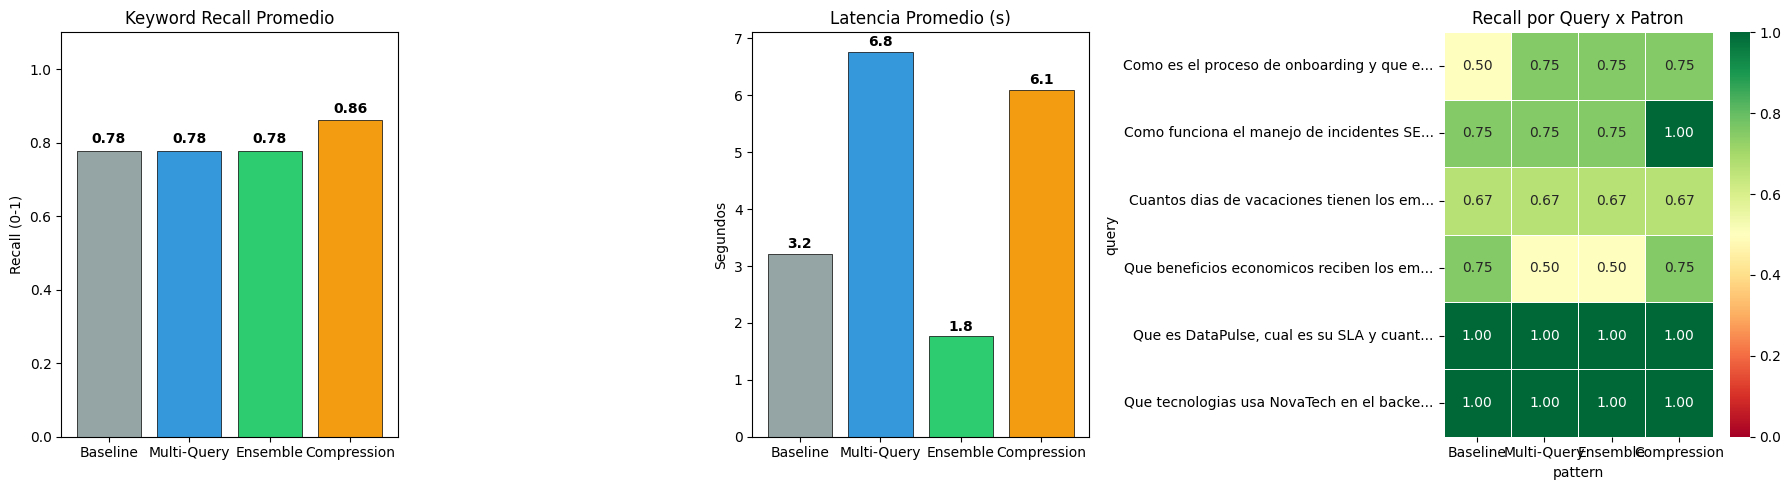

In [20]:
# Visualizacion: 3 paneles
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors_patterns = ['#95a5a6', '#3498db', '#2ecc71', '#f39c12']

# Recall
axes[0].bar(order, summary.loc[order, 'recall_promedio'],
            color=colors_patterns, edgecolor='black', linewidth=0.5)
axes[0].set_title('Keyword Recall Promedio')
axes[0].set_ylabel('Recall (0-1)')
axes[0].set_ylim(0, 1.1)
for i, v in enumerate(summary.loc[order, 'recall_promedio']):
    axes[0].text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

# Latencia
axes[1].bar(order, summary.loc[order, 'latencia_promedio'],
            color=colors_patterns, edgecolor='black', linewidth=0.5)
axes[1].set_title('Latencia Promedio (s)')
axes[1].set_ylabel('Segundos')
for i, v in enumerate(summary.loc[order, 'latencia_promedio']):
    axes[1].text(i, v + 0.1, f"{v:.1f}", ha='center', fontweight='bold')

# Recall por query (heatmap)
pivot = df_results.pivot(index='query', columns='pattern', values='recall')
pivot = pivot[order]
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn', vmin=0, vmax=1,
            ax=axes[2], linewidths=0.5)
axes[2].set_title('Recall por Query x Patron')

plt.tight_layout()
plt.show()

---
## Seccion 6: Cuando Usar Cada Patron

| Patron | Ventaja principal | Costo extra | Mejor para |
|--------|------------------|-------------|------------|
| **Baseline** | Simple, rapido, predecible | Ninguno | Prototipos, preguntas directas |
| **Multi-Query** | Mayor recall, cubre mas angulos | 1 LLM call extra + N retrievals | Preguntas complejas que tocan multiples temas |
| **Ensemble** | Combina semantica + keywords | BM25 index en memoria | Datos con nombres propios, acronimos, numeros |
| **Compression** | Contexto preciso, menos tokens | 1 LLM call por chunk recuperado | Chunks grandes, contexto limitado |
| **Conversacional** | Soporta dialogo multi-turno | 1 LLM call para reformular | Chatbots, asistentes interactivos |

### Combinaciones comunes en produccion

1. **Chatbot empresarial**: Conversacional + Ensemble
2. **Q&A sobre documentos**: Multi-Query + Compression
3. **Busqueda interna**: Ensemble (para nombres y codigos)

---
## Resumen

En esta notebook implementamos 5 patrones avanzados de RAG **desde los primitivos**:

| Patron | Que hace | Problema que resuelve |
|--------|----------|-----------------------|
| Multi-Query | Genera multiples queries con LLM | Bajo recall con una sola query |
| Ensemble + RRF | Combina semantic + BM25 retrieval | Falla con nombres propios y numeros |
| Compression | Extrae solo lo relevante de cada chunk | Contexto ruidoso, desperdicio de tokens |
| Conversacional | Reformula con historial de chat | Preguntas dependientes del contexto |
| Evaluacion | Compara patrones con metricas | No saber cual patron usar |

### Checklist de consolidacion

- [ ] Puedo explicar cuando Multi-Query mejora sobre el baseline
- [ ] Entiendo la diferencia entre busqueda semantica y BM25
- [ ] Se como funciona Reciprocal Rank Fusion para combinar rankings
- [ ] Comprendo como funciona la compresion contextual
- [ ] Puedo construir un RAG conversacional con memoria de sesion
- [ ] Se evaluar y comparar patrones con metricas cuantitativas
- [ ] Puedo elegir el patron adecuado segun el caso de uso